In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import nltk
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow import metrics


In [7]:
# Loading the dataset
news_train = pd.read_csv("/content/gdrive/My Drive/NLP Project/Fake_news_data.csv")

In [8]:
# We just conduct EDA and go over the dataset as whole and 
# see if there are any flaws in the structure that need to be corrected 
# We make a copy of the data and make a perform some analysis
# After doing some preprocessing steps we note that these data entries have no text available 
# We filter out the IDS of these data entries 


news_train_eda = news_train.copy()
news_train_eda['text'] = news_train_eda['text'].str.lower()
news_train_eda['text'] = news_train_eda['text'].replace('[^A-Za-z\s]','', regex=True)
news_train_eda['text'] = news_train_eda['text'].str.split()
ids = list(news_train_eda.loc[news_train_eda['text'].str.len() == 0 ,]['id'])
news_train_eda.loc[news_train['id'].isin(ids)]

,id,title,author,text,label
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,[],1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,[],1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,[],1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,[],1
492,492,Казахстан на страже ядерной безопасности | Нов...,NaN,[],1
...,...,...,...,...,...
20141,20141,Thomas Frank Explores Whether Hillary Clinton ...,NaN,[],1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,[],1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,[],1
20513,20513,SAID IN SPANISH: A Mexican Governor Meddles In...,Allan Wall,[],1


In [9]:
# However, the text column above is a copy of a generated data with 
# some proprocessing steps already performed on it
# We use those IDs to get an idea of how the actual data entries of this data looks like
# We see that either there are no ids or there are the text is not in English language
news_train.loc[news_train['id'].isin(ids)] 

,id,title,author,text,label
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1
492,492,Казахстан на страже ядерной безопасности | Нов...,NaN,В ноябре 2016 г. Мажилис Парламента Республики...,1
...,...,...,...,...,...
20141,20141,Thomas Frank Explores Whether Hillary Clinton ...,NaN,,1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,,1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,,1
20513,20513,SAID IN SPANISH: A Mexican Governor Meddles In...,Allan Wall,,1


In [10]:
# To resolve this we replace the "text" of the sentences we our "title"
news_train.loc[news_train["id"].isin(ids), "text"] = news_train.loc[
    news_train["id"].isin(ids), "title"
]

In [11]:
# We only use the first 15000 rows to generate a train data set. This will include the train test split.
# The rest 5800 rows, we keep that as unseen data to check how well the model is actually performing.
news_train = news_train.iloc[:14999,:] # we filter the first 15000 rows

In [12]:
# Now that we have our data ready we perform preprocessing steps on it
news_train = news_train.dropna()  # place this above the two cells
label = news_train["label"]  # Get a seperate columns for labels
news_train = news_train.drop("label", axis=1)
news_train.set_index("id", inplace=True)


news_train["text"] = news_train[
    "text"
].str.lower()  # convert the whole text to lower case to ensure uniformity

news_train["text"] = news_train["text"].replace("[^A-Za-z\s]", "", regex=True)
#Replace everything that is not letters or a space with a blank

news_train["text"] = news_train["text"].str.split()  # split our text column to a list

In [13]:
ps = PorterStemmer()
nltk.download("stopwords")


def remove_stopwords_and_stem(x):
    stopwds_lst = stopwords.words("english")
    sentence = ""
    for i in x:
        if i in stopwds_lst:
            x.remove(i)
    for k in range(len(x)):
        word = ps.stem(x[k])
        x[k] = word
    for j in x:
        sentence = sentence + j + " "
    sentence_final = sentence[:-1]
    return sentence_final

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
news_train['text'] = news_train['text'].apply(remove_stopwords_and_stem)

In [15]:
text_comments = list(news_train['text']) # make a list of all documents in the data

In [ ]:
# we calculate the number of unique words in the corpus to make a 
# one hot encoded vector representation for each word later
unique_words = []
for i in text_comments:
    for j in np.unique(i.split()):
        if j not in unique_words:
            unique_words.append(j)
len(unique_words)

104354

In [16]:
my_token = Tokenizer(num_words= 104354, oov_token='<OOV>') # assign a unique integer to each word in train corpus. Later for unseen data we have OOV tag.
my_token.fit_on_texts(text_comments)
one_hot_encoded = my_token.texts_to_sequences(text_comments)

In [17]:
equal_length = pad_sequences(one_hot_encoded, padding = 'post', maxlen= 500) # after one hot encoding the length of most vectors was around 500 
# so we pad each sequence to a fixed length of 500

In [19]:
model1 = Sequential() # we start our model by initial a sequential model in keras
model1.add(Embedding(104355, 50, input_length= 500)) # pass our one hot encoded vectors through an embedding layer reducing the dimenion to 50
model1.add(Bidirectional(LSTM(100, input_shape = (500,50), return_sequences=True))) # generate a bidirectional LSTM and get the output at each timestep
model1.add(LSTM(100, input_shape=(500,200))) # given that we got an out from bidirectional lstm of each time step we add it to a LSTM again in a sequential manner
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid')) # add a dense layer with activation as sigmoid as our output is binary
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[ 'accuracy', metrics.Recall()]) # compile our model
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           5217750   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 200)         120800    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,459,051
Trainable params: 5,459,051
Non-trainable params: 0
______________________________________________

In [20]:
input = np.array(equal_length) # make input array 
output = np.array(label) # make output labels

In [21]:
X_train,X_test,y_train,y_test = train_test_split(input, output, test_size=0.33, random_state=42) # make train test split for cross validation

In [22]:
history = model1.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=20, batch_size=64) # run the model with batch_size 64 and epochs 20

Epoch 1/20
138/138 [==============================] - 58s 356ms/step - loss: 0.6615 - accuracy: 0.6253 - recall: 0.6475 - val_loss: 0.5547 - val_accuracy: 0.6918 - val_recall: 0.8174
Epoch 2/20
138/138 [==============================] - 47s 342ms/step - loss: 0.5025 - accuracy: 0.7006 - recall: 0.8007 - val_loss: 0.5330 - val_accuracy: 0.6479 - val_recall: 0.2235
Epoch 3/20
138/138 [==============================] - 47s 340ms/step - loss: 0.4509 - accuracy: 0.7060 - recall: 0.7544 - val_loss: 0.5100 - val_accuracy: 0.6681 - val_recall: 0.2746
Epoch 4/20
138/138 [==============================] - 47s 339ms/step - loss: 0.4106 - accuracy: 0.7312 - recall: 0.8023 - val_loss: 0.6256 - val_accuracy: 0.6603 - val_recall: 0.9817
Epoch 5/20
138/138 [==============================] - 47s 341ms/step - loss: 0.4463 - accuracy: 0.7480 - recall: 0.8278 - val_loss: 0.5607 - val_accuracy: 0.6902 - val_recall: 0.8939
Epoch 6/20
138/138 [==============================] - 47s 341ms/step - loss: 0.4011 -

In [26]:
model1.save('/content/gdrive/My Drive/NLP Project/neural_network.h5') # save our network

In [27]:
import pickle
# save tokenizer
pickle.dump(
    my_token,
    open(
        "/content/gdrive/My Drive/NLP Project/Text_Vec.pkl",
        "wb",
    ),
)

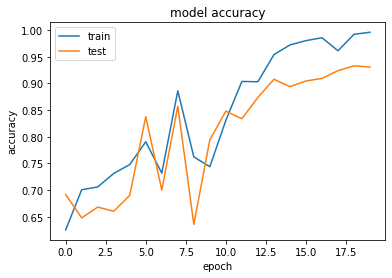

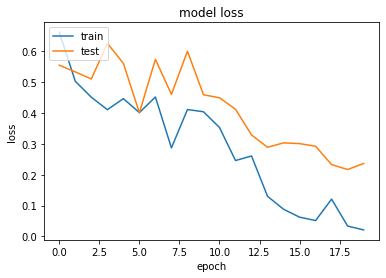

In [25]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()